# Lecture des fichiers et traitement du dataset (alignement des tokens obtenus grâce au Bert Tokenizer et des labels)

In [1]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import utils
import numpy as np
import math

#Opinion pair extraction dataset
class OPE_Dataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)
    #process tags
    def get_spans(self,tags):
        tags = tags.strip().split()
        length = len(tags)
        spans = []
        start = -1
        for i in range(length):
            if tags[i].endswith('B'):
                if start != -1:
                    spans.append([start, i - 1])
                start = i
            elif tags[i].endswith('O'):
                if start != -1:
                    spans.append([start, i - 1])
                    start = -1
        if start != -1:
            spans.append([start, length - 1])
        return spans

    def __getitem__(self, idx):
        line = self.data[idx]

        sentence_id = line['id']
        sentence = line['sentence']
        tokens = sentence.strip().split()
        original_length = len(tokens)
        token_range = []
        bert_tokens = self.tokenizer.encode(sentence)
        tokens_length = len(bert_tokens)
        padding = torch.zeros(100).long() #max sequence length is 100
        aspect_tags = torch.zeros(100).long()
        opinion_tags = torch.zeros(100).long()
        tags = torch.zeros(100, 100).long()
        mask = torch.zeros(100)

        for i in range(tokens_length):
            padding[i] = bert_tokens[i]

        mask[:tokens_length] = 1

        token_start = 1
        for i, w, in enumerate(tokens):
            token_end = token_start + len(self.tokenizer.encode(w, add_special_tokens=False))
            token_range.append([token_start, token_end-1])
            token_start = token_end
        assert tokens_length == token_range[-1][-1]+2

        aspect_tags[tokens_length:] = -1
        aspect_tags[0] = -1
        aspect_tags[tokens_length-1] = -1

        opinion_tags[tokens_length:] = -1
        opinion_tags[0] = -1
        opinion_tags[tokens_length - 1] = -1

        tags[:, :] = -1
        for i in range(1, tokens_length-1):
            for j in range(i, tokens_length-1):
                tags[i][j] = 0

        for label in line['triples']:
            label_aspect = label['target_tags']
            label_opinion = label['opinion_tags']
            label_aspect_span = self.get_spans(label_aspect)
            label_opinion_span = self.get_spans(label_opinion)

            '''set tag for aspect'''
            for l, r in label_aspect_span:
                start = token_range[l][0]
                end = token_range[r][1]
                for i in range(start, end+1):
                    for j in range(i, end+1):
                        tags[i][j] = 1
                for i in range(l, r+1):
                    set_tag = 1 if i == l else 2
                    al, ar = token_range[i]
                    aspect_tags[al] = set_tag
                    aspect_tags[al+1:ar+1] = -1
                    '''mask positions of sub words'''
                    tags[al+1:ar+1, :] = -1
                    tags[:, al+1:ar+1] = -1

            '''set tag for opinion'''
            for l, r in label_opinion_span:
                start = token_range[l][0]
                end = token_range[r][1]
                for i in range(start, end+1):
                    for j in range(i, end+1):
                        tags[i][j] = 2
                for i in range(l, r+1):
                    set_tag = 1 if i == l else 2
                    pl, pr = token_range[i]
                    opinion_tags[pl] = set_tag
                    opinion_tags[pl+1:pr+1] = -1
                    tags[pl+1:pr+1, :] = -1
                    tags[:, pl+1:pr+1] = -1

            for al, ar in label_aspect_span:
                for pl, pr in label_opinion_span:
                    for i in range(al, ar+1):
                        for j in range(pl, pr+1):
                            sal, sar = token_range[i]
                            spl, spr = token_range[j]
                            tags[sal:sar+1, spl:spr+1] = -1
                            if i > j:
                                tags[spl][sal] = 3
                            else:
                                tags[sal][spl] = 3

        token_ranges_length = len(token_range)
        token_ranges_padded_list = [[0,0]]*100
        for index,item in enumerate(token_range):
            token_ranges_padded_list[index]=token_range[index]

        token_ranges_padded_list = torch.tensor(token_ranges_padded_list)
        return sentence_id, padding, tokens_length, mask, original_length, token_ranges_padded_list, token_ranges_length, aspect_tags, tags


# Modele du Grid Tagging Scheme

In [2]:
import torch
import torch.nn

from transformers import AutoModel, AutoTokenizer

class MultiInferBert(torch.nn.Module):
    def __init__(self):
        super(MultiInferBert, self).__init__()

        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        self.cls_linear = torch.nn.Linear(768*2, 4) #bert features dim/class num
        self.feature_linear = torch.nn.Linear(768*2 + 4*3, 768*2) #bert features dim / class num / bert features dim
        self.dropout_output = torch.nn.Dropout(0.1)

    def multi_hops(self, features, mask, k):
        '''generate mask'''
        max_length = features.shape[1]
        mask = mask[:, :max_length]
        mask_a = mask.unsqueeze(1).expand([-1, max_length, -1])
        mask_b = mask.unsqueeze(2).expand([-1, -1, max_length])
        mask = mask_a * mask_b
        mask = torch.triu(mask).unsqueeze(3).expand([-1, -1, -1, 4])

        '''save all logits'''
        logits_list = []
        logits = self.cls_linear(features)
        logits_list.append(logits)

        for i in range(k):
            #probs = torch.softmax(logits, dim=3)
            probs = logits
            logits = probs * mask

            logits_a = torch.max(logits, dim=1)[0]
            logits_b = torch.max(logits, dim=2)[0]
            logits = torch.cat([logits_a.unsqueeze(3), logits_b.unsqueeze(3)], dim=3)
            logits = torch.max(logits, dim=3)[0]

            logits = logits.unsqueeze(2).expand([-1,-1, max_length, -1])
            logits_T = logits.transpose(1, 2)
            logits = torch.cat([logits, logits_T], dim=3)

            new_features = torch.cat([features, logits, probs], dim=3)
            features = self.feature_linear(new_features)
            logits = self.cls_linear(features)
            logits_list.append(logits)
        return logits_list

    def forward(self, tokens, masks):
        bert_feature = self.bert(tokens, masks)
        bert_feature = bert_feature[0]
        bert_feature = self.dropout_output(bert_feature)

        bert_feature = bert_feature.unsqueeze(2).expand([-1, -1, 100, -1]) #max_sequence_len=100
        bert_feature_T = bert_feature.transpose(1, 2)
        features = torch.cat([bert_feature, bert_feature_T], dim=3)
        logits = self.multi_hops(features, masks, 1) #nhops

        return logits[-1]


# Création des loaders

In [3]:
from torch.utils.data import DataLoader
import json
import os
import random

train_file = json.load(open('./res14_train.json'))
val_file = json.load(open('./res14_val.json'))

random.shuffle(train_file)
random.shuffle(val_file)

train_dataset = OPE_Dataset(train_file)
val_dataset = OPE_Dataset(val_file)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_combined_loss(train_loss_values, val_loss_values, epochs):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(epochs, train_loss_values, label='Train Loss', color='blue')

    # Plot validation loss
    plt.plot(epochs, val_loss_values, label='Validation Loss', color='red')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Entrainement et validation sur 15 epochs, utilisation des métriques précision/rappel/f1score

Epoch n° 0


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Aspect term	P:0.00000	R:0.00000	F1:0.00000
Opinion term	P:0.00000	R:0.00000	F1:0.00000
pair	P:0.00000	R:0.00000	F1:0.00000

Epoch n° 1


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Aspect term	P:0.00000	R:0.00000	F1:0.00000
Opinion term	P:0.00000	R:0.00000	F1:0.00000
pair	P:0.00000	R:0.00000	F1:0.00000

Epoch n° 2


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.60870	R:0.02881	F1:0.05501
Opinion term	P:1.00000	R:0.00404	F1:0.00805
pair	P:1.00000	R:0.00176	F1:0.00351

Epoch n° 3


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Aspect term	P:0.79675	R:0.40329	F1:0.53552
Opinion term	P:1.00000	R:0.02424	F1:0.04734
pair	P:0.00000	R:0.00000	F1:0.00000

Epoch n° 4


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.80387	R:0.59877	F1:0.68632
Opinion term	P:0.85000	R:0.44646	F1:0.58543
pair	P:0.89109	R:0.15817	F1:0.26866

Epoch n° 5


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.79237	R:0.76955	F1:0.78079
Opinion term	P:0.77401	R:0.83030	F1:0.80117
pair	P:0.79245	R:0.51670	F1:0.62553

Epoch n° 6


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Aspect term	P:0.78008	R:0.77366	F1:0.77686
Opinion term	P:0.78557	R:0.79192	F1:0.78873
pair	P:0.76214	R:0.55185	F1:0.64016

Epoch n° 7


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.77629	R:0.83539	F1:0.80476
Opinion term	P:0.75618	R:0.86465	F1:0.80679
pair	P:0.73663	R:0.62917	F1:0.67867

Epoch n° 8


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Aspect term	P:0.75265	R:0.87654	F1:0.80989
Opinion term	P:0.66719	R:0.85455	F1:0.74934
pair	P:0.62937	R:0.63269	F1:0.63103

Epoch n° 9


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Aspect term	P:0.77193	R:0.81481	F1:0.79279
Opinion term	P:0.80897	R:0.83838	F1:0.82341
pair	P:0.75427	R:0.62039	F1:0.68081

Epoch n° 10


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Aspect term	P:0.75786	R:0.84362	F1:0.79844
Opinion term	P:0.81336	R:0.83636	F1:0.82470
pair	P:0.76056	R:0.66432	F1:0.70919

Epoch n° 11


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Aspect term	P:0.76051	R:0.85597	F1:0.80542
Opinion term	P:0.81055	R:0.83838	F1:0.82423
pair	P:0.75191	R:0.69244	F1:0.72095

Epoch n° 12


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.78462	R:0.83951	F1:0.81113
Opinion term	P:0.80739	R:0.83838	F1:0.82260
pair	P:0.74088	R:0.67838	F1:0.70826

Epoch n° 13


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Aspect term	P:0.77071	R:0.82305	F1:0.79602
Opinion term	P:0.80989	R:0.86061	F1:0.83448
pair	P:0.74308	R:0.66081	F1:0.69953

Epoch n° 14


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Aspect term	P:0.77606	R:0.82716	F1:0.80080
Opinion term	P:0.80000	R:0.85657	F1:0.82732
pair	P:0.74951	R:0.67311	F1:0.70926

Best epoch :  11 
F1 from best epoch :  0.7209515096065874


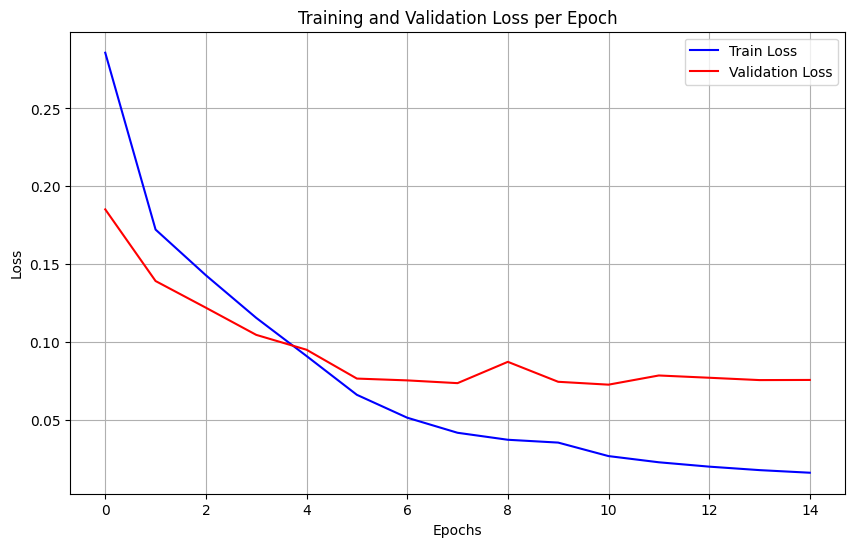

In [10]:
import torch.nn.functional as F
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GTS_model = MultiInferBert().to(device)
optimizer = torch.optim.Adam([
    {'params': GTS_model.bert.parameters(), 'lr': 5e-5},
    {'params': GTS_model.cls_linear.parameters()}
], lr=5e-5)

num_epochs = 15
best_f1 = 0
best_epoch = 0

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
        total_loss_train = 0.0
        total_loss_val = 0.0
        print('Epoch n°',epoch)
        GTS_model.train()
        for batch_index, (sentence_id, bert_tokens, tokens_length, mask, original_length, token_range_padded_list, token_range_length, aspect_tags, tags) in enumerate(tqdm(train_loader)):
            token_range = []
            for i in range(token_range_padded_list.size(0)):  # Loop over each item in the batch
              length = token_range_length[i].item()
              original_token_range = token_range_padded_list[i, :length]
              original_token_range_list = original_token_range.tolist()
              token_range.append(original_token_range_list)

            bert_tokens = bert_tokens.to(device)
            tokens_length = tokens_length.to(device)
            mask = mask.to(device)
            aspect_tags = aspect_tags.to(device)
            tags = tags.to(device)

            predictions = GTS_model(bert_tokens,mask)
            flat_predictions = predictions.reshape([-1, predictions.shape[3]])
            flat_tags = tags.reshape([-1])
            train_loss = F.cross_entropy(flat_predictions,flat_tags,ignore_index=-1)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            total_loss_train += train_loss.item()

        average_loss = total_loss_train / len(train_loader)
        train_loss_list.append(average_loss)

        val_preds = []
        labels_ids = []
        labels_original_lengths = []
        labels_tokens_lengths = []
        labels_token_ranges = []
        labels_tags = []
        GTS_model.eval()
        for batch_index, (sentence_id, bert_tokens, tokens_length, mask, original_length, token_range_padded_list, token_range_length, aspect_tags, tags) in enumerate(tqdm(val_loader)):
            token_range = []
            for i in range(token_range_padded_list.size(0)):  # Loop over each item in the batch
              length = token_range_length[i].item()
              original_token_range = token_range_padded_list[i, :length]
              original_token_range_list = original_token_range.tolist()
              token_range.append(original_token_range_list)

            bert_tokens = bert_tokens.to(device)
            tokens_length = tokens_length.to(device)
            mask = mask.to(device)
            aspect_tags = aspect_tags.to(device)
            tags = tags.to(device)
            with torch.no_grad():
                predictions = GTS_model(bert_tokens,mask)
                plot_preds = copy.deepcopy(predictions)
                flat_val_preds = plot_preds.reshape([-1, plot_preds.shape[3]])
                flat_val_tags = tags.reshape([-1])
                val_loss = F.cross_entropy(flat_val_preds,flat_val_tags,ignore_index=-1)
                predictions = torch.argmax(predictions, dim=3)
                val_preds.append(predictions)

            total_loss_val += val_loss.item()

            labels_tags.append(tags)
            labels_tokens_lengths.append(tokens_length)
            labels_original_lengths.extend(original_length)
            labels_token_ranges.extend(token_range)
            labels_ids.extend(sentence_id)


        average_val_loss = total_loss_val / len(val_loader)
        val_loss_list.append(average_val_loss)

        val_preds = torch.cat(val_preds, dim=0).cpu().tolist()
        labels_tags = torch.cat(labels_tags, dim=0).cpu().tolist()
        labels_tokens_lengths = torch.cat(labels_tokens_lengths, dim=0).cpu().tolist()


        metric = utils.Metric(val_preds, labels_tags, labels_tokens_lengths, labels_original_lengths, labels_token_ranges, ignore_index=-1)
        precision, recall, f1 = metric.score_uniontags()
        aspect_results = metric.score_aspect()
        opinion_results = metric.score_opinion()

        print('Aspect term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(aspect_results[0], aspect_results[1],aspect_results[2]))
        print('Opinion term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(opinion_results[0], opinion_results[1],opinion_results[2]))
        print('pair' + '\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}\n'.format(precision, recall, f1))

        if f1 > best_f1:
            model_path = './GTS_bert_model_pair.pt'
            torch.save(GTS_model, model_path)
            best_f1 = f1
            best_epoch = epoch
print('Best epoch : ',best_epoch,'\nF1 from best epoch : ',best_f1)
plot_combined_loss(train_loss_list, val_loss_list, range(0,num_epochs))

# Test sur des données du même ensemble (splitées)

In [ ]:
test_file = json.load(open('./res14_test.json'))

random.shuffle(test_file)

test_dataset = OPE_Dataset(test_file)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
GTS_model.eval()
test_preds = []
labels_ids = []
labels_original_lengths = []
labels_tokens_lengths = []
labels_token_ranges = []
labels_tags = []
for batch_index, (sentence_id, bert_tokens, tokens_length, mask, original_length, token_range_padded_list, token_range_length, aspect_tags, tags) in enumerate(tqdm(test_loader)):
    token_range = []
    for i in range(token_range_padded_list.size(0)):  # Loop over each item in the batch
      length = token_range_length[i].item()
      original_token_range = token_range_padded_list[i, :length]
      original_token_range_list = original_token_range.tolist()
      token_range.append(original_token_range_list)

    bert_tokens = bert_tokens.to(device)
    tokens_length = tokens_length.to(device)
    mask = mask.to(device)
    aspect_tags = aspect_tags.to(device)
    tags = tags.to(device)
    with torch.no_grad():
        predictions = GTS_model(bert_tokens,mask)
        predictions = torch.argmax(predictions, dim=3)
        test_preds.append(predictions)

    labels_tags.append(tags)
    labels_tokens_lengths.append(tokens_length)
    labels_original_lengths.extend(original_length)
    labels_token_ranges.extend(token_range)
    labels_ids.extend(sentence_id)

test_preds = torch.cat(test_preds, dim=0).cpu().tolist()
labels_tags = torch.cat(labels_tags, dim=0).cpu().tolist()
labels_tokens_lengths = torch.cat(labels_tokens_lengths, dim=0).cpu().tolist()


metric = utils.Metric(test_preds, labels_tags, labels_tokens_lengths, labels_original_lengths, labels_token_ranges, ignore_index=-1)
precision, recall, f1 = metric.score_uniontags()
aspect_results = metric.score_aspect()
opinion_results = metric.score_opinion()

print('Aspect term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(aspect_results[0], aspect_results[1],aspect_results[2]))
print('Opinion term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(opinion_results[0], opinion_results[1],opinion_results[2]))
print('pair' + '\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}\n'.format(precision, recall, f1))

100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Aspect term	P:0.80248	R:0.83647	F1:0.81912
Opinion term	P:0.79119	R:0.89336	F1:0.83918
pair	P:0.77380	R:0.69798	F1:0.73394



# Test sur un autre jeu de données du même domaine (reviews de restaurants)

In [ ]:
test_file = json.load(open('./res16_test.json'))

random.shuffle(test_file)

test_dataset = OPE_Dataset(test_file)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
GTS_model.eval()
test_preds = []
labels_ids = []
labels_original_lengths = []
labels_tokens_lengths = []
labels_token_ranges = []
labels_tags = []
for batch_index, (sentence_id, bert_tokens, tokens_length, mask, original_length, token_range_padded_list, token_range_length, aspect_tags, tags) in enumerate(tqdm(test_loader)):
    token_range = []
    for i in range(token_range_padded_list.size(0)):  # Loop over each item in the batch
      length = token_range_length[i].item()
      original_token_range = token_range_padded_list[i, :length]
      original_token_range_list = original_token_range.tolist()
      token_range.append(original_token_range_list)

    bert_tokens = bert_tokens.to(device)
    tokens_length = tokens_length.to(device)
    mask = mask.to(device)
    aspect_tags = aspect_tags.to(device)
    tags = tags.to(device)
    with torch.no_grad():
        predictions = GTS_model(bert_tokens,mask)
        predictions = torch.argmax(predictions, dim=3)
        test_preds.append(predictions)

    labels_tags.append(tags)
    labels_tokens_lengths.append(tokens_length)
    labels_original_lengths.extend(original_length)
    labels_token_ranges.extend(token_range)
    labels_ids.extend(sentence_id)

test_preds = torch.cat(test_preds, dim=0).cpu().tolist()
labels_tags = torch.cat(labels_tags, dim=0).cpu().tolist()
labels_tokens_lengths = torch.cat(labels_tokens_lengths, dim=0).cpu().tolist()


metric = utils.Metric(test_preds, labels_tags, labels_tokens_lengths, labels_original_lengths, labels_token_ranges, ignore_index=-1)
precision, recall, f1 = metric.score_uniontags()
aspect_results = metric.score_aspect()
opinion_results = metric.score_opinion()

print('Aspect term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(aspect_results[0], aspect_results[1],aspect_results[2]))
print('Opinion term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(opinion_results[0], opinion_results[1],opinion_results[2]))
print('pair' + '\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}\n'.format(precision, recall, f1))

100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


Aspect term	P:0.69202	R:0.81978	F1:0.75050
Opinion term	P:0.78253	R:0.87891	F1:0.82793
pair	P:0.67537	R:0.69884	F1:0.68691



# Test sur un autre jeu de données d'un domaine différent (reviews d'ordinateurs)

In [ ]:
test_file = json.load(open('./lap14_test.json'))

random.shuffle(test_file)

test_dataset = OPE_Dataset(test_file)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
GTS_model.eval()
test_preds = []
labels_ids = []
labels_original_lengths = []
labels_tokens_lengths = []
labels_token_ranges = []
labels_tags = []
for batch_index, (sentence_id, bert_tokens, tokens_length, mask, original_length, token_range_padded_list, token_range_length, aspect_tags, tags) in enumerate(tqdm(test_loader)):
    token_range = []
    for i in range(token_range_padded_list.size(0)):  # Loop over each item in the batch
      length = token_range_length[i].item()
      original_token_range = token_range_padded_list[i, :length]
      original_token_range_list = original_token_range.tolist()
      token_range.append(original_token_range_list)

    bert_tokens = bert_tokens.to(device)
    tokens_length = tokens_length.to(device)
    mask = mask.to(device)
    aspect_tags = aspect_tags.to(device)
    tags = tags.to(device)
    with torch.no_grad():
        predictions = GTS_model(bert_tokens,mask)
        predictions = torch.argmax(predictions, dim=3)
        test_preds.append(predictions)

    labels_tags.append(tags)
    labels_tokens_lengths.append(tokens_length)
    labels_original_lengths.extend(original_length)
    labels_token_ranges.extend(token_range)
    labels_ids.extend(sentence_id)

test_preds = torch.cat(test_preds, dim=0).cpu().tolist()
labels_tags = torch.cat(labels_tags, dim=0).cpu().tolist()
labels_tokens_lengths = torch.cat(labels_tokens_lengths, dim=0).cpu().tolist()


metric = utils.Metric(test_preds, labels_tags, labels_tokens_lengths, labels_original_lengths, labels_token_ranges, ignore_index=-1)
precision, recall, f1 = metric.score_uniontags()
aspect_results = metric.score_aspect()
opinion_results = metric.score_opinion()

print('Aspect term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(aspect_results[0], aspect_results[1],aspect_results[2]))
print('Opinion term\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}'.format(opinion_results[0], opinion_results[1],opinion_results[2]))
print('pair' + '\tP:{:.5f}\tR:{:.5f}\tF1:{:.5f}\n'.format(precision, recall, f1))

100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Aspect term	P:0.62334	R:0.50321	F1:0.55687
Opinion term	P:0.72349	R:0.73109	F1:0.72727
pair	P:0.59248	R:0.34679	F1:0.43750

